Danny's dataset ztf-1a has 3,18,818 systems and light curves in three bands: r,g and i. But when we put the following constrains:
1. System has 2 images only
2. System has over 200 datapoints in light curves in the three bands (r,g,i)
3. Time delay $dt>=10$ days and $0.5<= \mu2/\mu1 <= 2.0$

we have only 433 systems. By visually looking into the light curves of these systems we tested our methods on the following systems which have good looking light curves. 

Here we apply our fitting method based on **template 1 (log-normal) + crossing statistics up to 4th order + stretch** on Danny's dataset (ztf-1a).

In this notebook, **we run longer MCMC chains (using emcee): (most having steps=100,000; burn=15,000).** 
Note that, in this notebook, work on the same systems as in "Applying_Danny_short.ipynb"

In [13]:
%reset -f

In [14]:
import lmfit
import matplotlib.pyplot as plt
import pystan
import emcee
from scipy.optimize import curve_fit
from lmfit import Model
import matplotlib
import numpy as np
import corner
plt.rcParams['figure.figsize'] = [12, 8]

In [15]:
import pandas as pd
datapath="/home/users/satadru/lensed_supernovae/data"
fin=datapath+'/ztf-1a.h5'
df1I=pd.read_hdf(fin, 'image')

In [16]:
import sys
def get_mu_dt(sysno):
    print("="*80)
    mu=np.array((df1I[df1I['sysno']==sysn])['mu']);dt=np.array((df1I[df1I['sysno']==sysn])['td'])
    print(df1I[df1I['sysno']==sysn])
    if(len(mu)!=2):
        print("Not a 2-image system...")
        sys.exit()
    
    idx=np.argsort(dt);dt=dt[idx]; mu=mu[idx]
    dt1=dt[1]-dt[0]; mu1=np.abs(mu[1]/mu[0])
    print("\nRelative magnification, mu=",mu1, "time delay dt=",dt1,"\n","="*80)
    return mu1,dt1

In [17]:
#template 1: equ(19)
def mod(x,dt,t0,n,xk,s,c0,c1,c2,c3,c4):    
    mean=n;sig=xk;
    x=x-t0;
    xmax=np.amax(x)
    x=x-dt;
    x=x-s*x;
    #idx=np.where(x<1e-15)[0]
    x[x<1e-15]=1e-16
    fx=(1.0/(sig*np.sqrt(2.0*np.pi)*x))*np.exp(-0.5*(np.log(x)-mean)**2/(sig*sig))
    #fx[idx]=0.0
    
    xs=x/xmax
    #print("len=",len(xs[xs<0.5]))
    fx_mod=fx*(c0+c1*xs+c2*(2.0*xs*xs-1)+c3*(4.0*xs*xs*xs-3.0*xs) + c4*(8.0*xs*xs*xs*xs-8.0*xs*xs+1.0));
    return fx_mod

In [18]:
#with lmfit emcee (MCMC)
p = lmfit.Parameters()
p.add_many(('mu1', 1.0, True, 0.4,2.5),('dt1',5.0, True,0,60.0) ,('t0',0.0, False,0.0,60.0));

p.add_many(('nr', 1.0, True, 0.1,10.0), ('tkr', 0.1, True, 0.0,3.0),('sr', 0.01,True, 0.0,0.99));
p.add_many(('c0r', 1.0, True,None,None),('c1r', 0.1, True, None,None),('c2r', 0.1, True, None,None),
           ('c3r', 0.1, True, None,None) ,('c4r', 0.1,True, None,None))

p.add_many(('ng', 1.0, True, 0.1,10.0), ('tkg', 0.1, True, 0.0,3.0),('sg', 0.01,True, 0.0,0.99))#, ;
p.add_many(('c0g', 1.0, True,None,None),('c1g', 0.1, True, None,None),('c2g', 0.1, True, None,None),
           ('c3g', 0.1,True, None,None) ,('c4g', 0.1,True, None,None))

p.add_many(('nni', 1.0, True, 0.0,10.0), ('tki', 0.1, True, 0.0,3.0),('si', 0.01,True, 0.0,0.99));
p.add_many(('c0i', 1.0, True,None,None),('c1i', 0.1, True, None,None),('c2i', 0.1, True, None,None),
          ('c3i', 0.1, True, None,None),('c4i', 0.1, True, None,None))

#p.add_many(('nz', 1.0, True, 0.1,10.0), ('tkz', 0.10, True, 0.0,3.0),('sz', 0.01,True, 0.0,0.99));
#p.add_many(('c0z', 1.0, True,None,None),('c1z', 0.1, True, None,None),('c2z', 0.1,True, None,None),
#          ('c3z', 0, False, None,None))

def residual(p):
    v = p.valuesdict()
    
    B1=(mod(tr,0,v['t0'],v['nr'],v['tkr'],v['sr'],v['c0r'],v['c1r'],v['c2r'],v['c3r'],v['c4r'])
            +v['mu1']*mod(tr,v['dt1'],v['t0'],v['nr'],v['tkr'],v['sr'],v['c0r'],v['c1r'],v['c2r'],v['c3r'],v['c4r'])-fr)/sigfr;
        
    B2=(mod(tg,0,v['t0'],v['ng'],v['tkg'],v['sg'],v['c0g'],v['c1g'],v['c2g'],v['c3g'],v['c4g'])
            +v['mu1']*mod(tg,v['dt1'],v['t0'],v['ng'],v['tkg'],v['sg'],v['c0g'],v['c1g'],v['c2g'],v['c3g'],v['c4g'])-fg)/sigfg;
    
    B3=(mod(ti,0,v['t0'],v['nni'],v['tki'],v['si'],v['c0i'],v['c1i'],v['c2i'],v['c3i'],v['c4i'])
            +v['mu1']*mod(ti,v['dt1'],v['t0'],v['nni'],v['tki'],v['si'],v['c0i'],v['c1i'],v['c2i'],v['c3i'],v['c4i'])-fi)/sigfi;
    
    #B4=(mod(tz,v['t0'],v['nz'],v['tkz'],v['sz'],v['c0z'],v['c1z'],v['c2z'],v['c3z'],0)
            #+v['mu1']*mod(tz-v['dt1'],v['t0'],v['nz'],v['tkz'],v['sz'],v['c0z'],v['c1z'],v['c2z'],v['c3z'],0)-fz)/sigfz;
    
    return np.concatenate((B1,B2,B3))


p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

In [19]:
import corner
#print(res2.params.valuesdict().values())

def plot_contour(sample,mu_des,dt_des):
    emcee_plot = corner.corner(sample.flatchain[['mu1','dt1']], labels=['mu','dt'],color='g', smooth=1,
                        levels=(0.68,0.95),plot_density=0, fill_contours=1, plot_datapoints=0.000001,
                           truths=list([mu_des,dt_des]))
    plt.show(emcee_plot)

In [20]:
def plot_func(res):
    highest_prob = np.argmax(res.lnprob)
    hp_loc = np.unravel_index(highest_prob, res.lnprob.shape)
    mle_soln = res.chain[hp_loc]
    #[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=data
    #print(mle_soln.shape)
    #sys.exit()
    #for i, par in enumerate(p):
    #p[par].value = mle_soln[i]
    #print(mle_soln[i])
    print("\nMaximum likelihood Estimation")
    print('-----------------------------')
    #print(len(mle_soln))
    t0m=0.0;
    [mum,dtm,
     nrm,tkrm,srm,c0rm,c1rm,c2rm,c3rm,c4rm,
     ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm,c4gm,
     nim,tkim,sim,c0im,c1im,c2im,c3im,c4im,
     lnm]=mle_soln;
    
    #print(mle_soln)
    #print("g-band: ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm=",ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm)
    #mum,dtm=1.4/2.4,15.0
    #print("Maximum liklihood: mu=",mum, "dt=",dtm)
    #sys.exit()
    #print(p)
    Ps1r=mod(tr,0,t0m,nrm,tkrm,srm,c0rm,c1rm,c2rm,c3rm,c4rm)
    Ps2r=mum*mod(tr,dtm,t0m,nrm,tkrm,srm,c0rm,c1rm,c2rm,c3rm,c4rm)
    Psr=Ps1r+Ps2r

    
    Ps1g=mod(tg,0,t0m,ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm,c4gm)
    Ps2g=mum*mod(tg,dtm,t0m,ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm,c4gm)
    Psg=Ps1g+Ps2g

    
    Ps1i=mod(ti,0,t0m,nim,tkim,sim,c0im,c1im,c2im,c3im,c4im)
    Ps2i=mum*mod(ti,dtm,t0m,nim,tkim,sim,c0im,c1im,c2im,c3im,c4im)
    Psi=Ps1i+Ps2i
 

    plt.rcParams['figure.figsize'] = [12, 8]
    plt.title(r'template 1')
    plt.errorbar(tr,fr,yerr=sigfr,fmt='r*',label=r"data r: %s ponits"%(len(tr))) #data
    plt.plot(tr, Psr, c="r")

    
    plt.errorbar(tg,fg,yerr=sigfg,fmt='g*',label=r"data g: %s ponits"%(len(tg))) #data
    plt.plot(tg, Psg, c="g")
    
    plt.errorbar(ti,fi,yerr=sigfi,fmt='b*',label=r"data b: %s ponits"%(len(ti))) #data
    plt.plot(ti, Psi, c="b")

    plt.legend(loc=0)
    plt.show()
    
    chisqr=np.sum((Psr-fr)**2/sigfr**2); chisqg=np.sum((Psg-fg)**2/sigfg**2);  
    chisqi=np.sum((Psi-fi)**2/sigfi**2);

    print("Maximum liklihood: mu=",mum, "dt=",dtm)
    print("\nChi^2 r=",chisqr,"Chi^2 g=",chisqg,"Chi^2 i=",chisqi)
    print("data points::: r-band:",len(tr)," g-band:",len(tg)," i-band:",len(ti))
    plt.show()
    
    plt.subplot(2, 2, 1)
    plt.title(r'r-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(tr,fr,yerr=sigfr,fmt='r*',label=r"data r") #data
    plt.plot(tr, Psr, c="r")
    plt.plot(tr, Ps1r,c="r",ls="--")
    plt.plot(tr, Ps2r,c="r",ls="dotted")

    
    plt.subplot(2, 2, 2)
    plt.title(r'g-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(tg,fg,yerr=sigfg,fmt='g*',label=r"data g") #data
    plt.plot(tg, Psg, c="g")
    plt.plot(tg, Ps1g,c="g",ls="--")
    plt.plot(tg, Ps2g,c="g",ls="dotted")
    

    
    plt.subplot(2, 2, 3)
    plt.title(r'i-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    t=ti
    plt.errorbar(t,fi,yerr=sigfi,fmt='b*',label=r"data i") #data
    plt.plot(t, Psi, c="b")
    plt.plot(t, Ps1i,c="b",ls="--")
    plt.plot(t, Ps2i,c="b",ls="dotted")

    
    plt.legend(loc=0)
    plt.show()


In [21]:
def read_data(sysn):
    inp_path='../read_data/ztf-1a/'
    bands=['ztfr','ztfg','ztfi']
    fileN='ztf-1a_stackedflux_sysn%s_band_'%(sysn)

    fileNr=inp_path+fileN+bands[0];print(fileNr)
    fileNg=inp_path+fileN+bands[1];print(fileNg)
    fileNi=inp_path+fileN+bands[2];print(fileNi)

    tr,fr,sigfr=np.loadtxt(fileNr,usecols=[0,1,2], unpack=True)
    tg,fg,sigfg=np.loadtxt(fileNg,usecols=[0,1,2], unpack=True)
    ti,fi,sigfi=np.loadtxt(fileNi,usecols=[0,1,2], unpack=True)

    t_mins=np.array([np.amin(tr), np.amin(tg), np.amin(ti)])
    t_maxs=np.array([np.amax(tr), np.amax(tg), np.amax(ti)])
    t_min=np.amin(t_mins)-1e-5; t_max=np.amax(t_maxs);

    # we substract a fixed time, it should not have any effect on the pystan results
    tr=tr-t_min; tg=tg-t_min; ti=ti-t_min; 
    t_max=t_max-t_min; t_min=0.0;

    c=['r','g','b']
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.errorbar(tr,fr,yerr=sigfr,fmt='%s*'%(c[0]),label=r"r-band: %s points"%(len(tr)))
    plt.errorbar(tg,fg,yerr=sigfg,fmt='%s*'%(c[1]),label=r"g-band: %s points"%(len(tg)))
    plt.errorbar(ti,fi,yerr=sigfi,fmt='%s*'%(c[2]),label=r"i-band: %s points"%(len(ti)))
    plt.legend(loc=0)
    plt.show()

    mu_des,dt_des=get_mu_dt(sysn)
    return [tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]

In [22]:
def fitting(sysn,step,burn,thin,nwalker):
    res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=burn, steps=step, thin=thin, 
                         nwalkers=nwalker,params=p, is_weighted=False,seed=20145)
    lmfit.report_fit(res.params,show_correl=False,min_correl=0.9);
    plot_contour(res, mu_des,dt_des)
    plot_func(res)
    return res;

In [27]:
sys_no_list_full2=[62250655,70776641,70861347,71488663,76226169,76277223,77272711,81741581,82320026, 93507840, 94866642
                   ,95598133,96069612, 96640307,98361511]

print(len(sys_no_list_full2))

15


**Below we apply template 1 (equ(19)) + stretch + 4th order crossing statistics on the following systems from Danny's datasets**

In [28]:
sys_no_list=[76277223,77272711,81741581,82320026, 93507840, 94866642
                   ,95598133,96069612, 96640307,98361511];
Nsys=len(sys_no_list);
print("Total no. of systems to be studied=",Nsys)
results=np.zeros(Nsys,dtype=object)
i=0;

Total no. of systems to be studied= 10


In [29]:
step=100000; burn=15000; nwalker=150; thin=3;


Starting i=0, SystemNo=76277223 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn76277223_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn76277223_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn76277223_band_ztfi


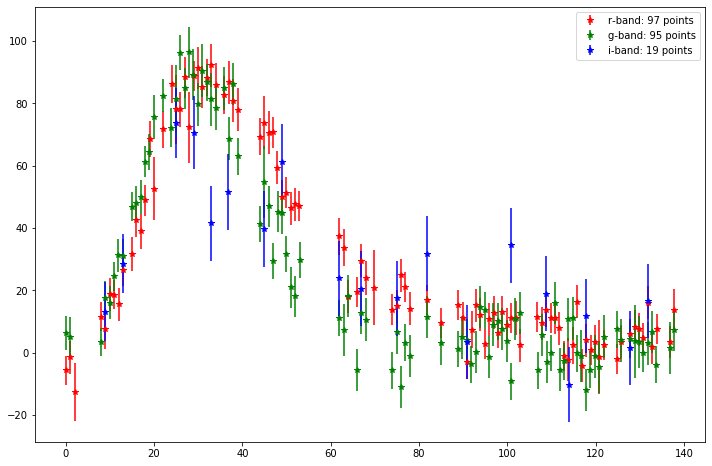

         td         x         y        mu     sysno  imno
0   0.00000 -0.756923 -1.717038  1.469109  76277223     0
1  11.95422 -0.104589  0.408715 -0.960652  76277223     1

Relative magnification, mu= 0.6539011559540892 time delay dt= 11.954219974059791 


100%|██████████| 100000/100000 [1:22:50<00:00, 20.12it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 27 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 9322.21905249  5194.38918858  8884.25783307  6813.35239682
  2563.31582742 11200.14023072 11186.45751803 11318.87377142
 11425.56716532 11034.41728787  7084.02351615  2542.36362031
  9174.72457018 11537.75025976 11053.45870275 11773.17552194
 10924.47550941 11652.30927008 10118.78956017  9616.2107279
  8847.89879268 11119.07792763 11132.87052146 11268.58328233
 10653.6930112  11325.87245647  5971.51829697]
[[Variables]]
    mu1:        0.80586109 +/- 0.37452113 (46.47%) (init = 1)
    dt1:        10.2400344 +/- 1.33252662 (13.01%) (init = 5)
    t0:         0 (fixed)
    nr:         1.25005385 +/- 0.57815565 (46.25%) (init = 1)
    tkr:        0.58956103 +/- 0.06565763 (11.14%) (init = 0.1)
    sr:         0.90178003 +/- 0.07115772 (7.89%) (init = 0.01)
    c0r:        11419.6990 +/- 33608.7922 (294.31%) (init = 1)
    c1

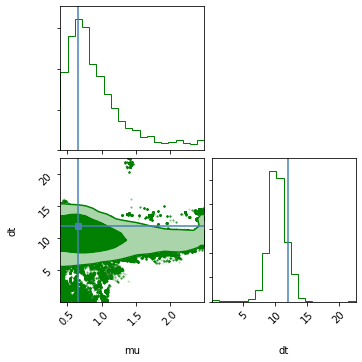


Maximum likelihood Estimation
-----------------------------


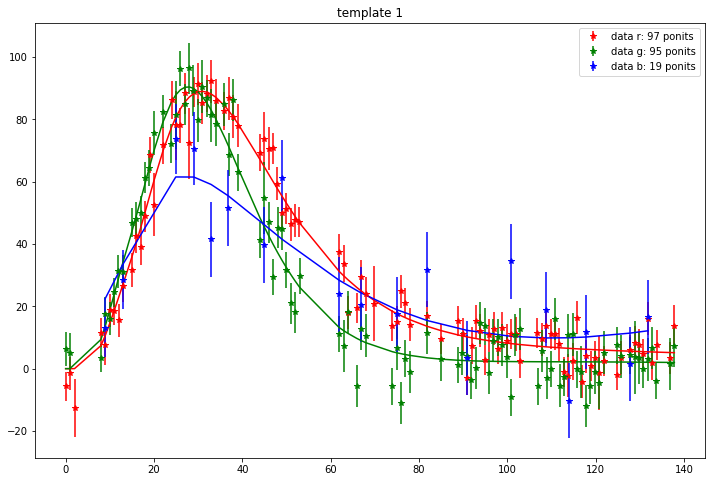

Maximum liklihood: mu= 0.8164079175748442 dt= 9.93841371409069

Chi^2 r= 85.96144968055599 Chi^2 g= 101.15486621550895 Chi^2 i= 19.144447576096614
data points::: r-band: 97  g-band: 95  i-band: 19


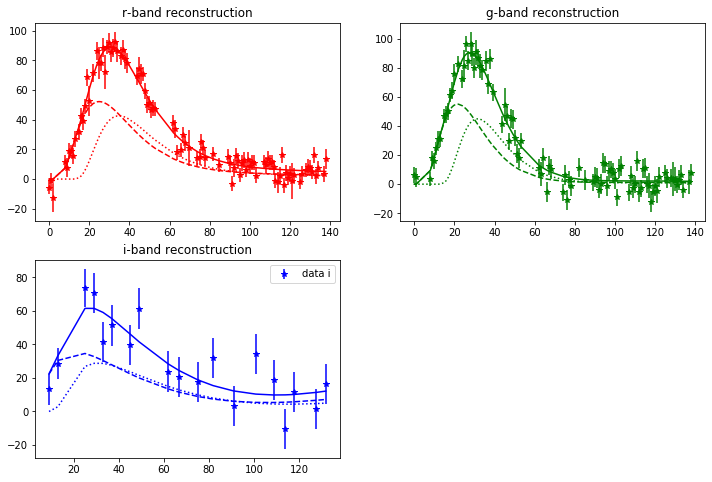

In [30]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1


Starting i=1, SystemNo=77272711 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn77272711_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn77272711_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn77272711_band_ztfi


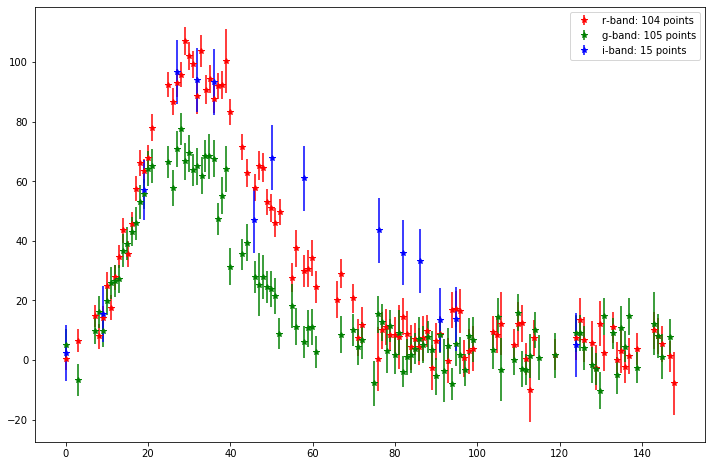

          td         x         y        mu     sysno  imno
0   0.000000 -0.378859 -0.890278  4.328552  77272711     0
1  10.892283  0.134633  0.514327 -2.423690  77272711     1

Relative magnification, mu= 0.5599308596212493 time delay dt= 10.892282642150361 


100%|██████████| 100000/100000 [1:29:39<00:00, 18.59it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 26 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 8169.97738965  4223.9151263   7638.87022437  4576.17011337
  1300.28225658 11124.22252532 11328.57238521 10798.93057713
 11238.20723537 11325.79425573  6335.60307286  2514.94623863
  6336.45723718 11146.26012946 11148.61241792 11063.92689737
 11305.07342832 11124.59986692 10646.68511744  9538.06831138
  8994.05308891 10649.05885966 10845.76052027 10627.29406649
 10777.42495405 10634.8678922   4413.48733034]
[[Variables]]
    mu1:        0.87197246 +/- 0.27005807 (30.97%) (init = 1)
    dt1:        10.6544562 +/- 1.00659556 (9.45%) (init = 5)
    t0:         0 (fixed)
    nr:         0.75170935 +/- 0.38299320 (50.95%) (init = 1)
    tkr:        0.55593679 +/- 0.04941464 (8.89%) (init = 0.1)
    sr:         0.93414549 +/- 0.03534198 (3.78%) (init = 0.01)
    c0r:        15405.7411 +/- 54341.7494 (352.74%) (init = 1)
    c1r

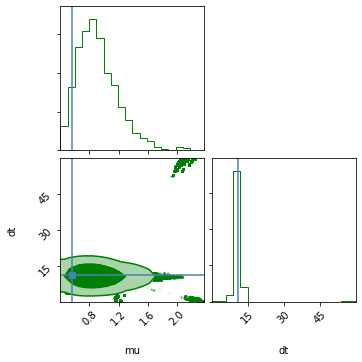


Maximum likelihood Estimation
-----------------------------


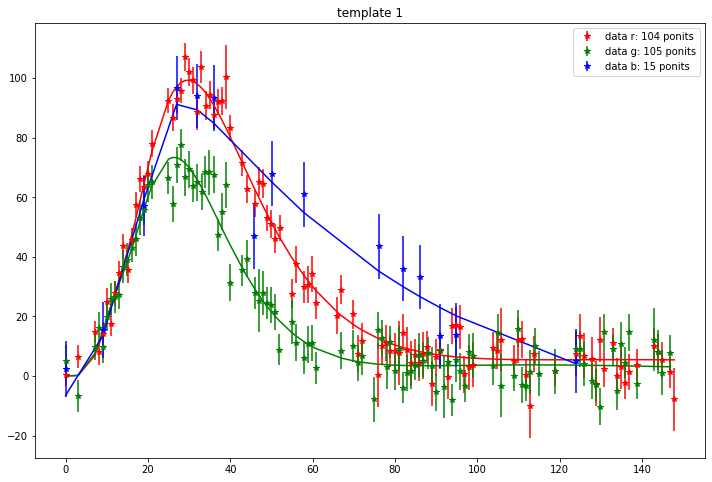

Maximum liklihood: mu= 0.9842706821719358 dt= 10.06417776511354

Chi^2 r= 93.37899559904676 Chi^2 g= 103.57017759768557 Chi^2 i= 9.539318478670724
data points::: r-band: 104  g-band: 105  i-band: 15


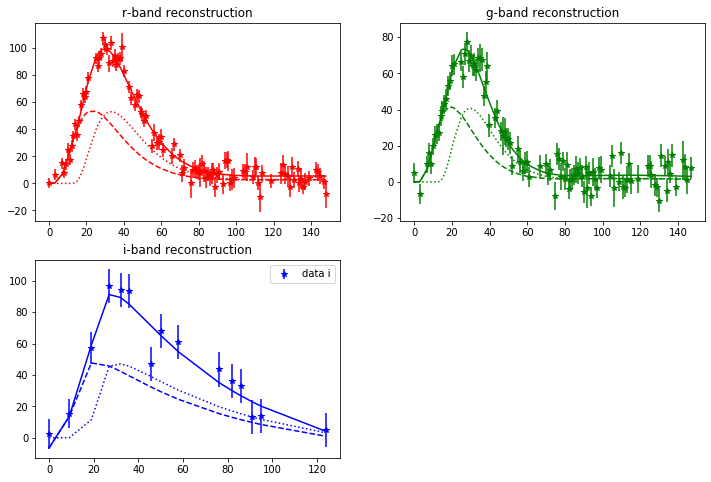

In [31]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1


Starting i=2, SystemNo=81741581 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn81741581_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn81741581_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn81741581_band_ztfi


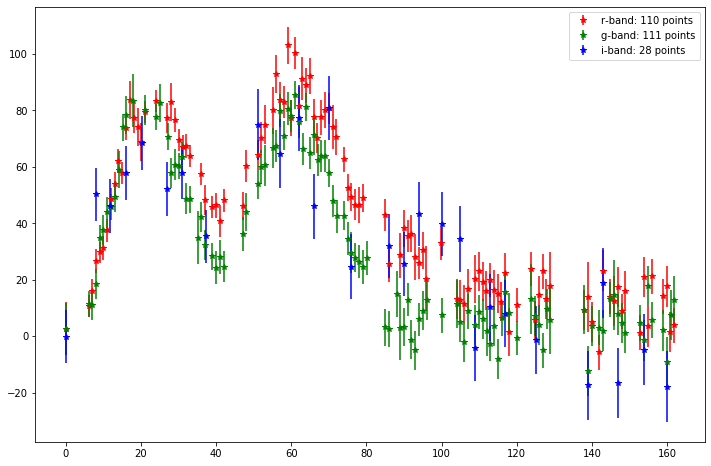

          td         x         y        mu     sysno  imno
0   0.000000 -1.954279  0.563153  1.999355  81741581     0
1  38.840946  0.588700 -0.243501 -1.746679  81741581     1

Relative magnification, mu= 0.8736211963694505 time delay dt= 38.84094609142513 


100%|██████████| 100000/100000 [1:13:22<00:00, 22.72it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 26 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 8264.53387931  8403.89382632 10890.56671704 10673.35807943
  2929.0764011  11288.32635042 11778.81167264 11274.53224244
 11733.70360233 11221.78594156 12513.17655569 11909.09157169
  8002.99968986 11727.40744388 11685.23910129 11666.68938577
 11245.62334598 12226.5160347   9673.36585061  7547.92567445
  9561.25384854 11405.95770259 11571.79497748 11450.911876
 11260.27015724 11069.30353031   124.63694959]
[[Variables]]
    mu1:        1.81440839 +/- 0.73539344 (40.53%) (init = 1)
    dt1:        7.32912274 +/- 2.70135890 (36.86%) (init = 5)
    t0:         0 (fixed)
    nr:         3.02163445 +/- 1.29994486 (43.02%) (init = 1)
    tkr:        1.71343151 +/- 0.40864443 (23.85%) (init = 0.1)
    sr:         0.97982726 +/- 0.02393831 (2.44%) (init = 0.01)
    c0r:       -13739.6026 +/- 183930.696 (1338.69%) (init = 1)
    c1

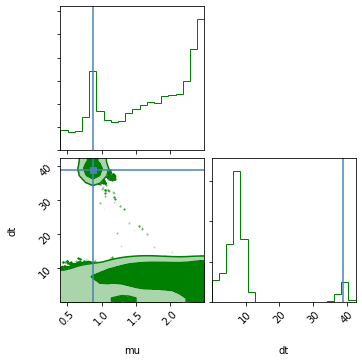


Maximum likelihood Estimation
-----------------------------


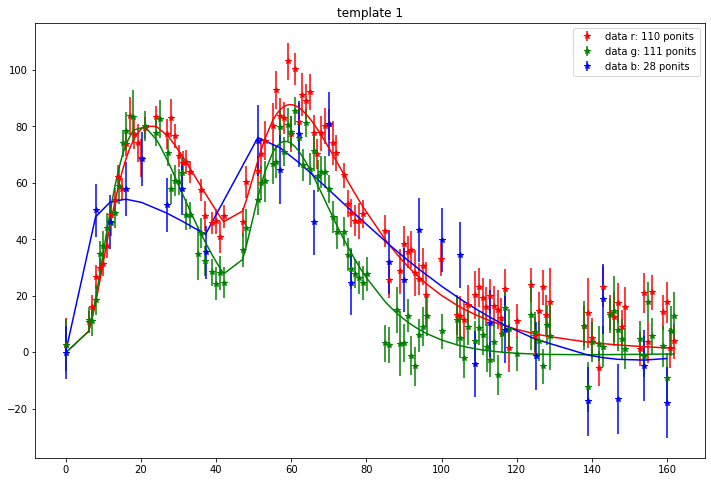

Maximum liklihood: mu= 0.8463036949803017 dt= 39.44162093059735

Chi^2 r= 164.78094473969378 Chi^2 g= 123.85354750440463 Chi^2 i= 34.26184082138965
data points::: r-band: 110  g-band: 111  i-band: 28


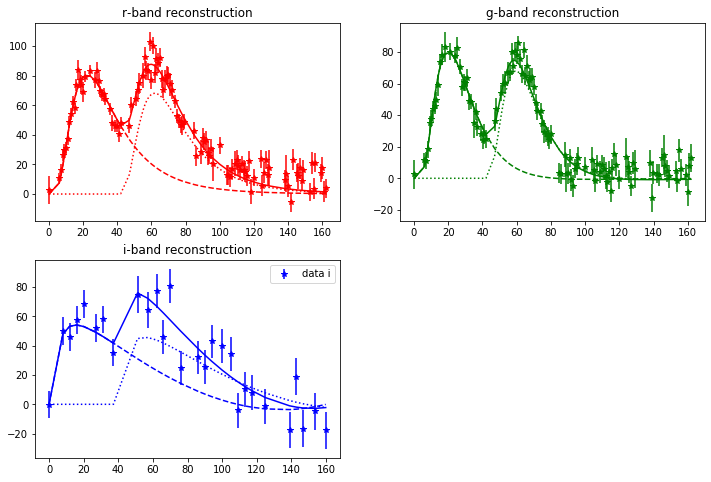

In [32]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1


Starting i=3, SystemNo=82320026 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn82320026_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn82320026_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn82320026_band_ztfi


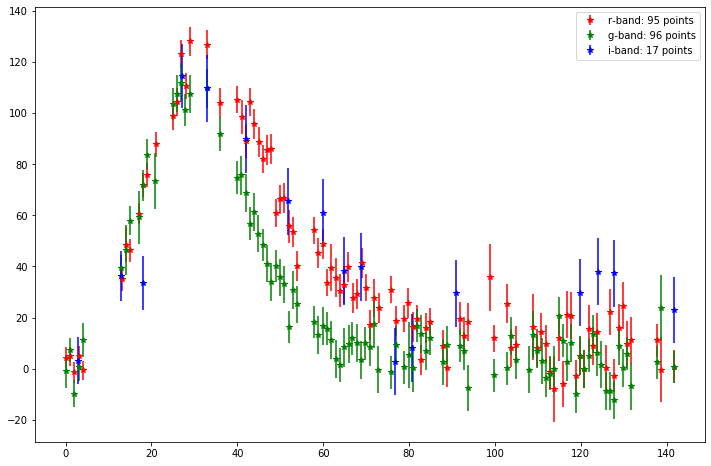

          td         x         y        mu     sysno  imno
0   0.000000 -2.269131 -1.376640  2.834500  82320026     0
1  10.138578  1.156551  0.195531 -1.823814  82320026     1

Relative magnification, mu= 0.6434340942666226 time delay dt= 10.138578229218076 


100%|██████████| 100000/100000 [1:20:58<00:00, 20.58it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 27 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [10315.90359882  5408.47222703  8567.14533939  5346.46273169
  7740.62925247 11129.36103393 10814.65173242 11016.73553512
 10578.53108031 10474.40551333  7351.87716653  5191.33150211
  7599.33249483 12115.03522542 11214.73930463 10992.4532658
 10874.04438259 11223.84734164  6970.11559179  7158.84290519
  7335.87310945 11085.6273316  10454.77741153 10901.76058074
 11137.97023858 11471.36918834 10998.80556973]
[[Variables]]
    mu1:        0.80960143 +/- 0.38233713 (47.23%) (init = 1)
    dt1:        12.0783301 +/- 1.47510614 (12.21%) (init = 5)
    t0:         0 (fixed)
    nr:         2.99747231 +/- 0.56609684 (18.89%) (init = 1)
    tkr:        0.55173411 +/- 0.08120827 (14.72%) (init = 0.1)
    sr:         0.50923308 +/- 0.27929144 (54.85%) (init = 0.01)
    c0r:        11598.0413 +/- 24090.2594 (207.71%) (init = 1)
    c

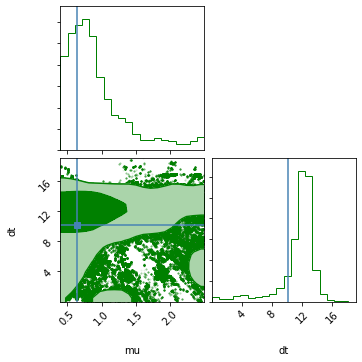


Maximum likelihood Estimation
-----------------------------


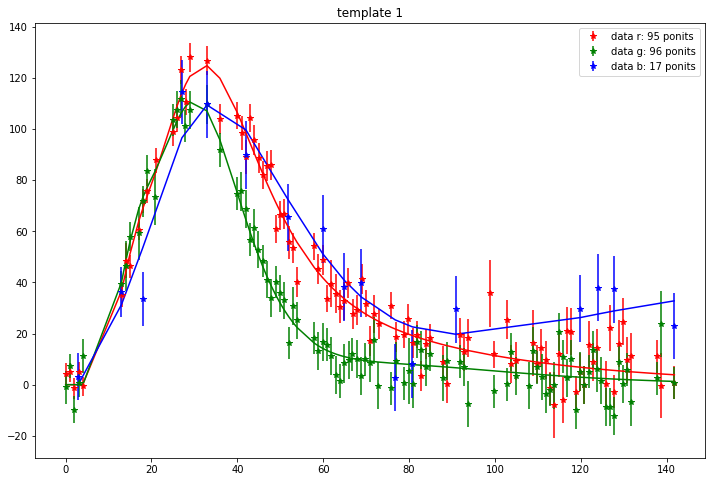

Maximum liklihood: mu= 0.8346336206876509 dt= 12.839527499476562

Chi^2 r= 118.98409124985123 Chi^2 g= 73.27172468487741 Chi^2 i= 13.723213289674717
data points::: r-band: 95  g-band: 96  i-band: 17


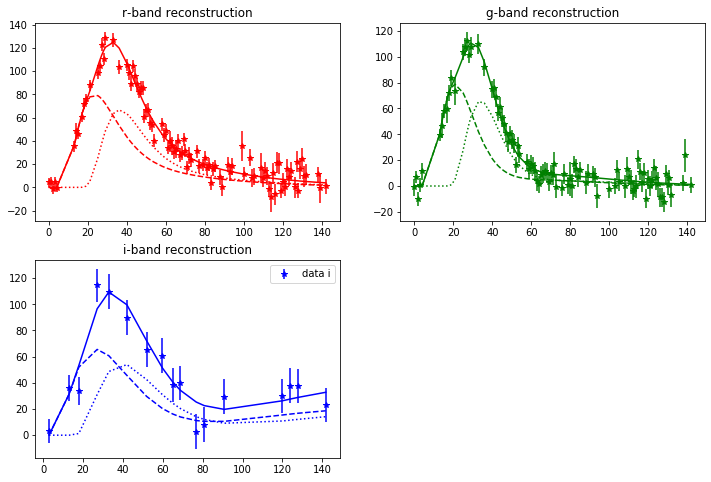

In [33]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1


Starting i=4, SystemNo=93507840 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn93507840_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn93507840_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn93507840_band_ztfi


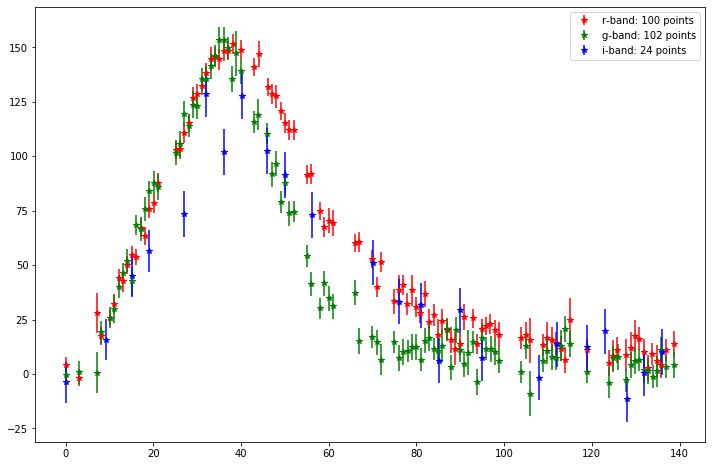

          td         x         y        mu     sysno  imno
0   0.000000 -0.832823  0.490882  1.819410  93507840     0
1  16.586913  0.275769 -0.132359 -2.356924  93507840     1

Relative magnification, mu= 1.2954329769796462 time delay dt= 16.586913215359022 


100%|██████████| 100000/100000 [1:46:16<00:00, 15.68it/s] 


The chain is shorter than 50 times the integrated autocorrelation time for 23 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 4523.97259703  1537.52997626  7934.06091193   519.38210592
   937.21817037 10569.86070982 10426.35711077 10581.36451807
 10438.31649147 10603.31282123  8661.25023186  5524.98392907
   578.85851917 10562.8951147  10470.85752345 10538.12667417
 10476.18815095 10468.22015832  9103.49427785  7501.7122736
  9226.96988472 10185.10272787 10378.4186201  10166.10687264
 10365.79965294 10050.9380306   7656.17862868]
[[Variables]]
    mu1:        1.19704281 +/- 0.08221154 (6.87%) (init = 1)
    dt1:        16.2942370 +/- 0.29906202 (1.84%) (init = 5)
    t0:         0 (fixed)
    nr:         1.00388103 +/- 0.40280284 (40.12%) (init = 1)
    tkr:        0.60341285 +/- 0.03462792 (5.74%) (init = 0.1)
    sr:         0.93302632 +/- 0.02554578 (2.74%) (init = 0.01)
    c0r:        14513.8268 +/- 874197.725 (6023.21%) (init = 1)
    c1r:

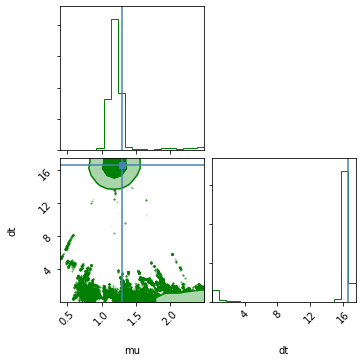


Maximum likelihood Estimation
-----------------------------


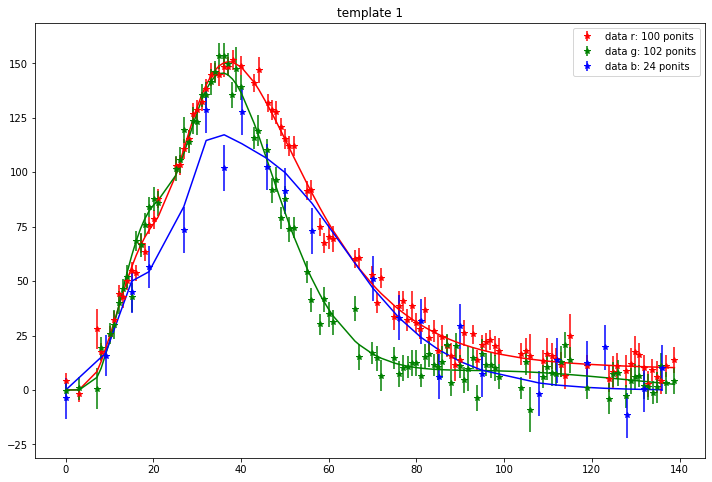

Maximum liklihood: mu= 1.1696049231442072 dt= 16.60030542774122

Chi^2 r= 81.62771764140584 Chi^2 g= 100.16876000513474 Chi^2 i= 22.34641009835603
data points::: r-band: 100  g-band: 102  i-band: 24


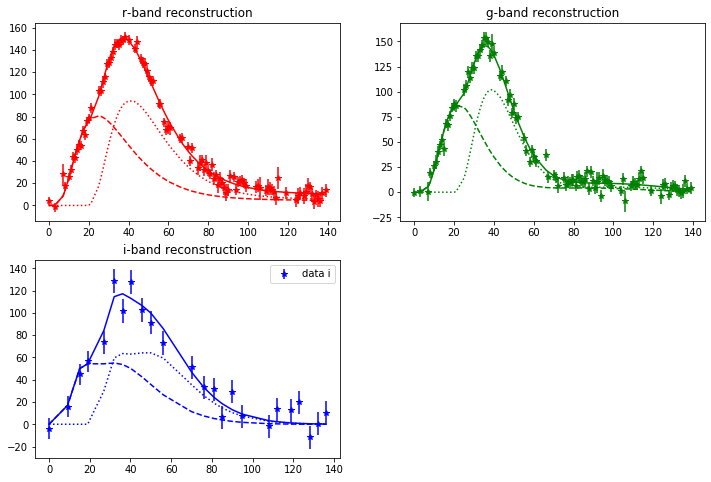

In [34]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1


Starting i=5, SystemNo=94866642 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn94866642_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn94866642_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn94866642_band_ztfi


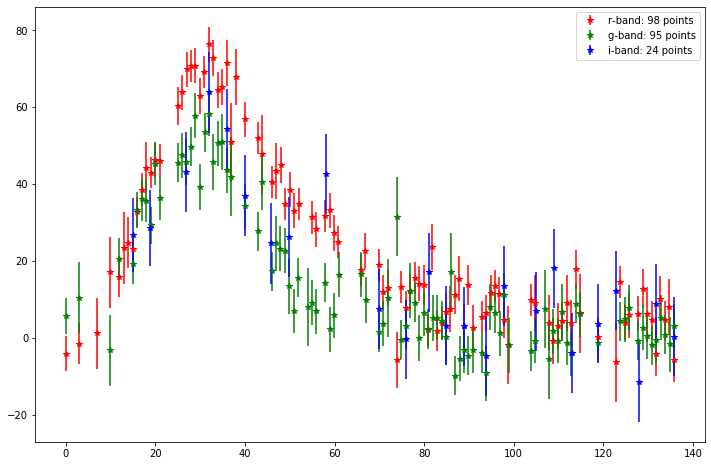

          td         x         y        mu     sysno  imno
0   0.000000 -0.021418  0.926029  2.009092  94866642     0
1  11.563159  0.093338 -0.270748 -1.322860  94866642     1

Relative magnification, mu= 0.6584366709519885 time delay dt= 11.563158608958478 


100%|██████████| 100000/100000 [1:16:09<00:00, 21.88it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 27 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 9785.01569809  5449.26914774  8899.98631866  5507.50718891
  3123.78966832 11197.97158053 11449.07668043 10883.19634959
 11531.12197575 11667.89935362  6665.92516315  7390.10517885
  8665.27825861 11383.53240754 10984.04782677 10924.89241534
 11146.81329668 10758.06436902  9140.94289071  8480.39174885
  8742.17880371 10959.6322784  11045.46665787 11136.43024894
 10986.70456111 11500.22250266  8098.10663499]
[[Variables]]
    mu1:        0.98386633 +/- 0.50009810 (50.83%) (init = 1)
    dt1:        11.5326253 +/- 1.99593611 (17.31%) (init = 5)
    t0:         0 (fixed)
    nr:         0.95320689 +/- 0.60238773 (63.20%) (init = 1)
    tkr:        0.60948071 +/- 0.07530438 (12.36%) (init = 0.1)
    sr:         0.90763671 +/- 0.06252498 (6.89%) (init = 0.01)
    c0r:        1194.84158 +/- 9448.97611 (790.81%) (init = 1)
    c

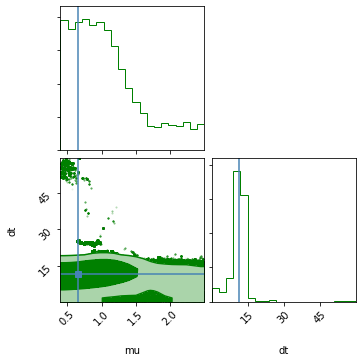


Maximum likelihood Estimation
-----------------------------


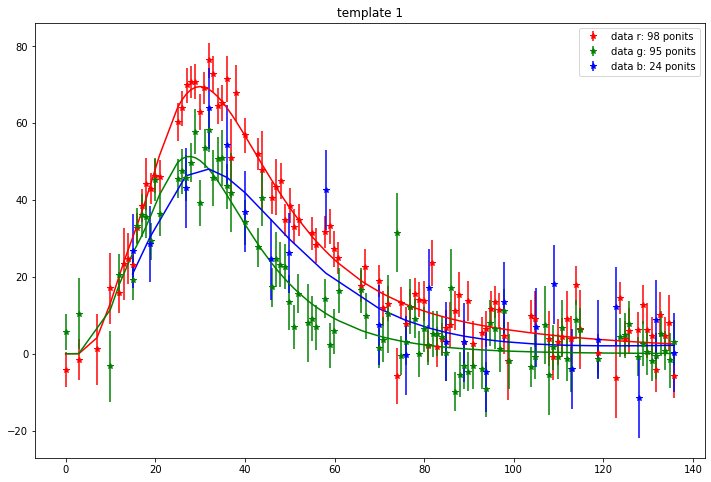

Maximum liklihood: mu= 0.8962077463738628 dt= 10.896843115508421

Chi^2 r= 92.41749157044826 Chi^2 g= 89.6492039557717 Chi^2 i= 18.829819509345917
data points::: r-band: 98  g-band: 95  i-band: 24


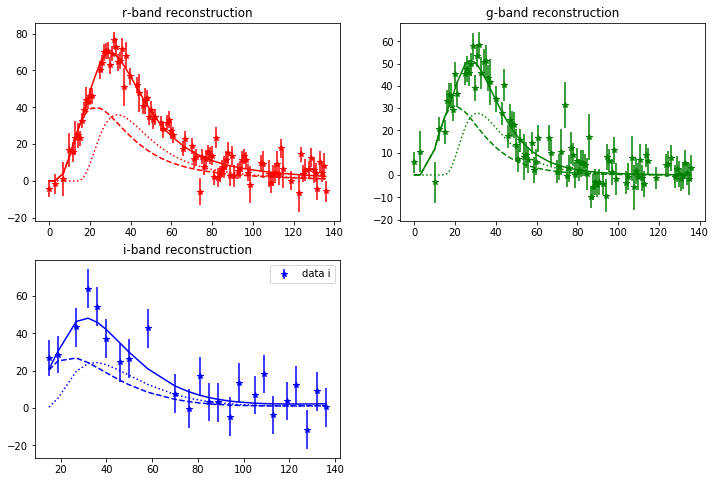

In [35]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1


Starting i=6, SystemNo=95598133 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn95598133_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn95598133_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn95598133_band_ztfi


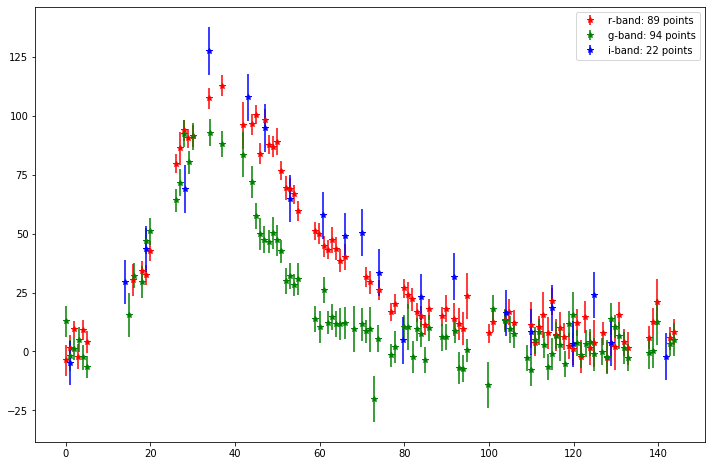

          td         x         y        mu     sysno  imno
0   0.000000  0.067419  0.664718  2.077891  95598133     0
1  12.610509 -0.067178 -0.270044 -3.868166  95598133     1

Relative magnification, mu= 1.861583017030622 time delay dt= 12.610509415252585 


100%|██████████| 100000/100000 [1:29:23<00:00, 18.65it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 26 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [10715.79237094  7054.34675845  7327.56823797  5580.76607268
  1062.82778091 10683.94396247 10852.69377691 10426.38235566
 11088.15006498 10746.00086605  5722.19224453  4380.0787524
  8258.56433784 11495.23463322 11207.90714199 11647.14617235
 11076.30440673 11444.64384439  6827.95867174  5681.23810901
  8952.38884489 11395.16217638 10897.39981759 11290.38313545
 10631.35069581 10956.08435216  7852.76261135]
[[Variables]]
    mu1:        1.69540547 +/- 0.67306217 (39.70%) (init = 1)
    dt1:        13.3834103 +/- 1.92504199 (14.38%) (init = 5)
    t0:         0 (fixed)
    nr:         0.96517200 +/- 0.35249889 (36.52%) (init = 1)
    tkr:        0.54556811 +/- 0.08232914 (15.09%) (init = 0.1)
    sr:         0.93141185 +/- 0.02717244 (2.92%) (init = 0.01)
    c0r:        1332.29603 +/- 41003.1085 (3077.63%) (init = 1)
    c

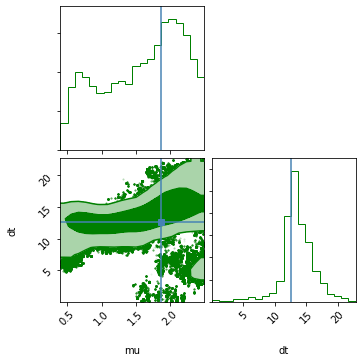


Maximum likelihood Estimation
-----------------------------


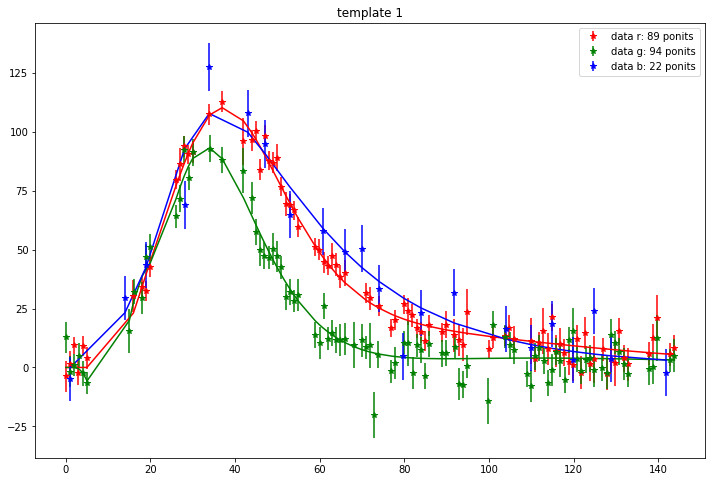

Maximum liklihood: mu= 0.7089975000594011 dt= 12.53374837021523

Chi^2 r= 76.90812701378104 Chi^2 g= 97.12564097433888 Chi^2 i= 26.091314058806834
data points::: r-band: 89  g-band: 94  i-band: 22


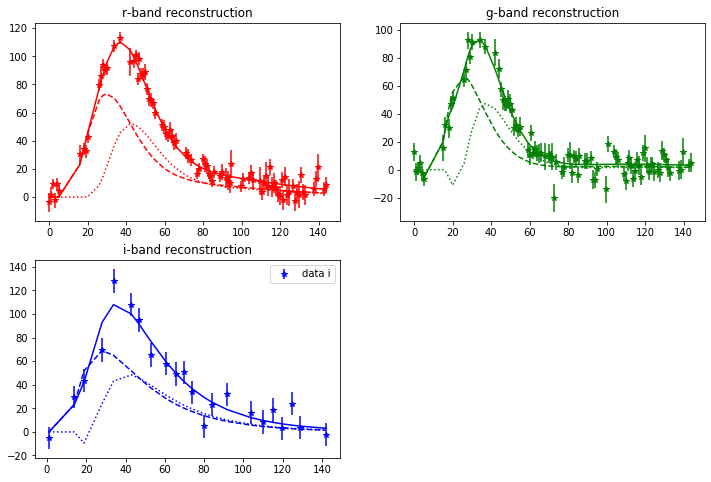

In [36]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1


Starting i=7, SystemNo=96069612 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn96069612_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn96069612_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn96069612_band_ztfi


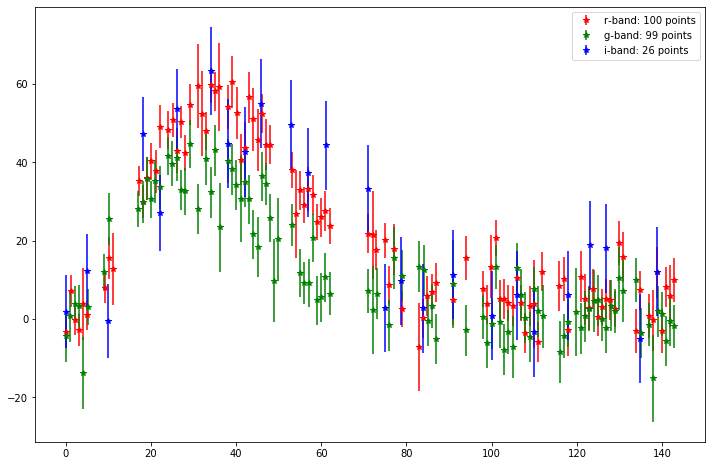

          td         x         y        mu     sysno  imno
0   0.000000 -0.414920 -1.290557  2.215287  96069612     0
1  16.911647 -0.171287  0.512577 -1.411805  96069612     1

Relative magnification, mu= 0.6373011778684664 time delay dt= 16.911646800327556 


100%|██████████| 100000/100000 [1:19:54<00:00, 20.86it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 27 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 7283.51476807  8430.92684149  8633.34194755  5401.02513024
  5022.60001662 11205.57588809 11188.18772877 11356.68837329
 11373.30680609 11788.84709505  7905.77391162  8298.23247556
  8483.21613462 10932.28488044 11578.56915007 10587.29985181
 11734.10300206 10784.88395666  9421.84530697  8700.44445754
  8537.81012492 10343.54436355 11136.44069241 10522.91869093
 11377.72783182 10814.87410258  5399.15673808]
[[Variables]]
    mu1:        0.55866290 +/- 0.47554411 (85.12%) (init = 1)
    dt1:        15.9638292 +/- 3.53056311 (22.12%) (init = 5)
    t0:         0 (fixed)
    nr:         1.48794329 +/- 0.70650285 (47.48%) (init = 1)
    tkr:        0.62524030 +/- 0.11056281 (17.68%) (init = 0.1)
    sr:         0.89468594 +/- 0.07185835 (8.03%) (init = 0.01)
    c0r:        3108.69048 +/- 10447.6456 (336.08%) (init = 1)
    c

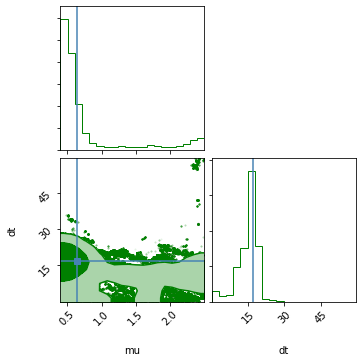


Maximum likelihood Estimation
-----------------------------


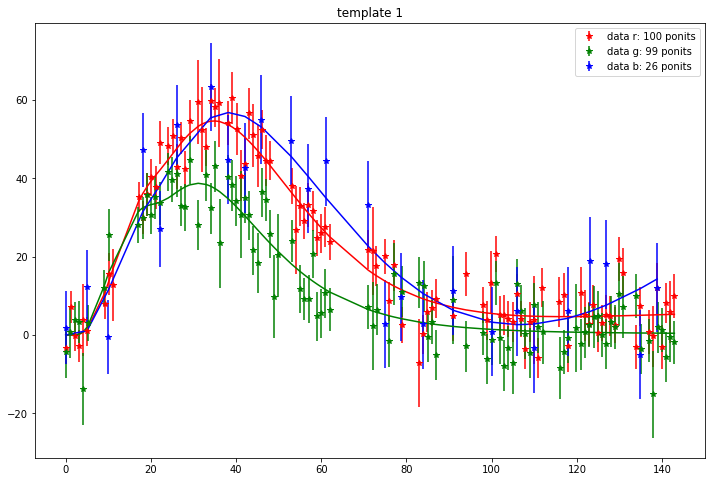

Maximum liklihood: mu= 0.497490737018936 dt= 17.167670686166492

Chi^2 r= 92.89016492510657 Chi^2 g= 80.02556491813779 Chi^2 i= 20.14235380495769
data points::: r-band: 100  g-band: 99  i-band: 26


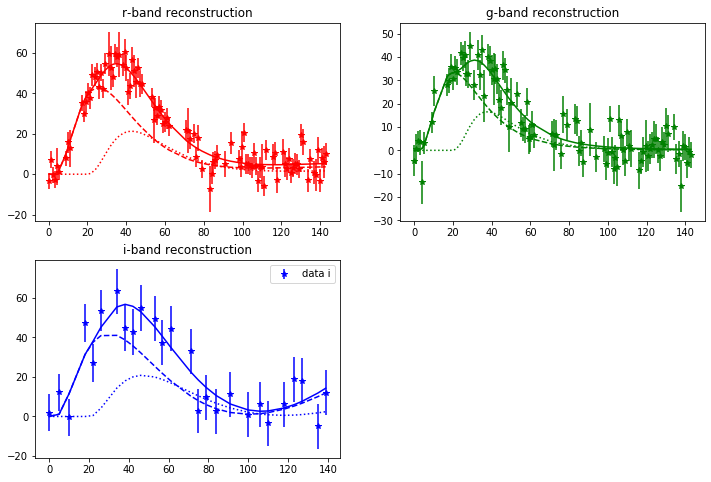

In [37]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1


Starting i=8, SystemNo=96640307 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn96640307_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn96640307_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn96640307_band_ztfi


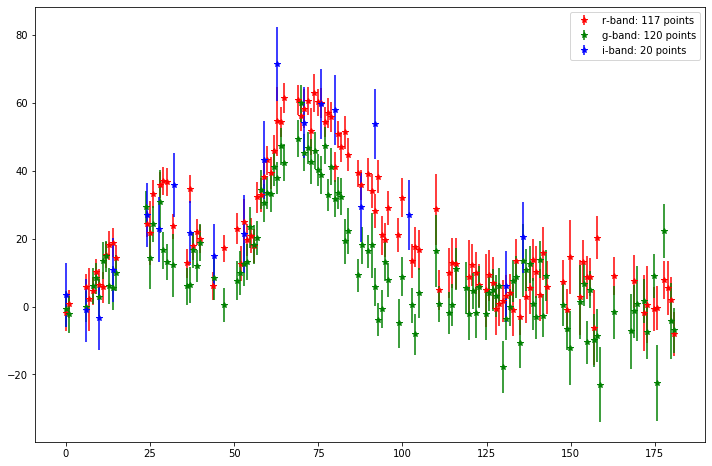

          td         x         y        mu     sysno  imno
0   0.000000 -1.086365 -1.057323  1.788935  96640307     0
1  44.736525  0.331810  0.391956 -3.307460  96640307     1

Relative magnification, mu= 1.8488423409543704 time delay dt= 44.73652460881287 


100%|██████████| 100000/100000 [1:33:19<00:00, 17.86it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 27 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 5607.60188733  3075.35362558  7765.7519648   5114.46972169
  4770.44660472 11054.99023119 11302.6170679  11100.25289871
 11288.1012929  11289.70633903  5881.12416747  5229.69687111
  6766.89015471 10826.76288157 11325.98206833 10953.3583374
 11264.27555181 11198.70518711  9930.59027621  8453.70840421
  8618.73995311 11375.33593463 11227.12362855 11303.97048552
 11471.61390453 11354.91986285  4441.9657206 ]
[[Variables]]
    mu1:        1.89203557 +/- 0.13329676 (7.05%) (init = 1)
    dt1:        45.2666997 +/- 0.86191739 (1.90%) (init = 5)
    t0:         0 (fixed)
    nr:         1.81092501 +/- 0.69053058 (38.13%) (init = 1)
    tkr:        0.57155996 +/- 0.05737601 (10.04%) (init = 0.1)
    sr:         0.83662596 +/- 0.12813171 (15.32%) (init = 0.01)
    c0r:        1229.00219 +/- 38860.4003 (3161.95%) (init = 1)
    c1

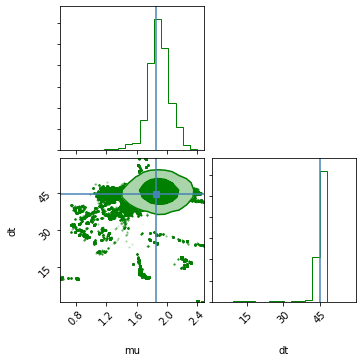


Maximum likelihood Estimation
-----------------------------


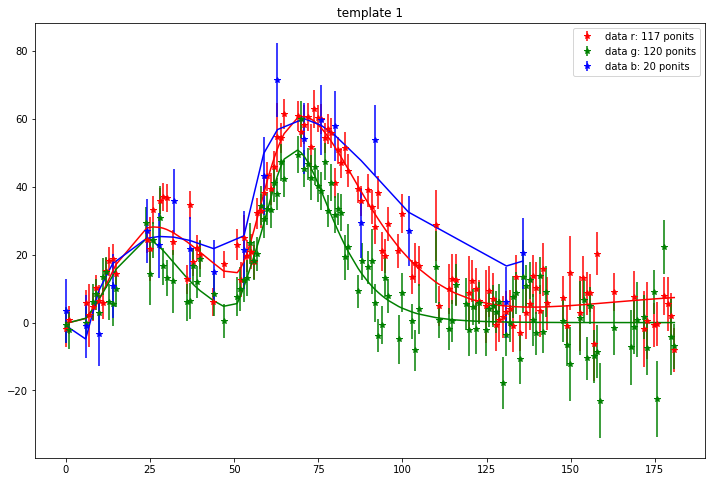

Maximum liklihood: mu= 2.0295978428084993 dt= 44.9542078146031

Chi^2 r= 123.8060421122021 Chi^2 g= 134.72542620078337 Chi^2 i= 12.973775392424917
data points::: r-band: 117  g-band: 120  i-band: 20


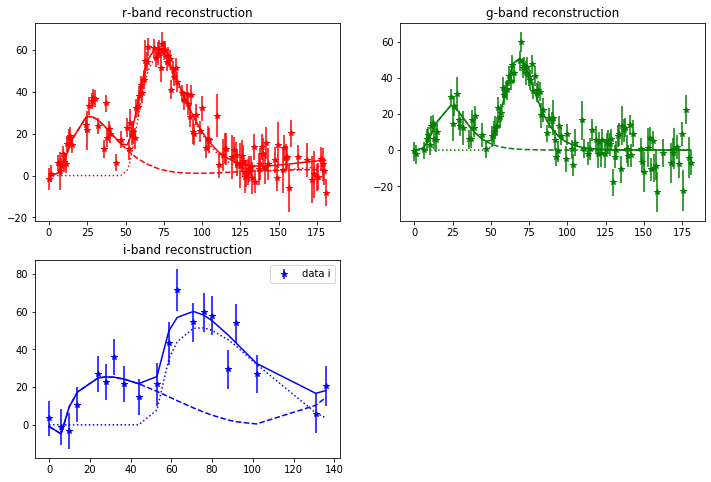

In [38]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1


Starting i=9, SystemNo=98361511 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn98361511_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn98361511_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn98361511_band_ztfi


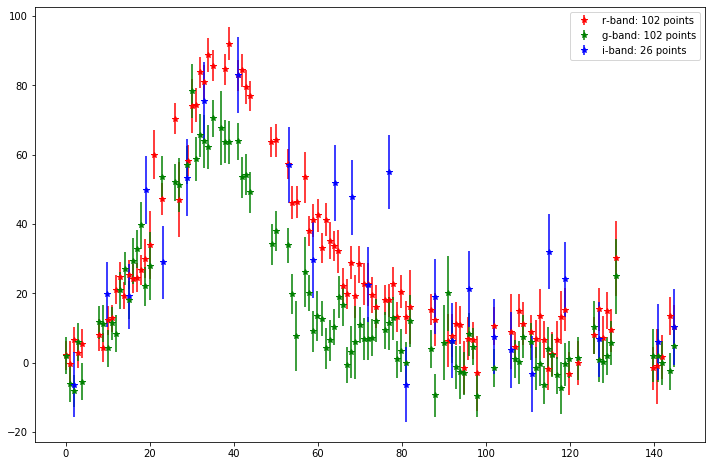

          td         x         y        mu     sysno  imno
0   0.000000 -1.010885 -0.629734  1.993482  98361511     0
1  14.177286  0.158568  0.499183 -2.633954  98361511     1

Relative magnification, mu= 1.3212833367312236 time delay dt= 14.177286163844027 


100%|██████████| 100000/100000 [1:25:36<00:00, 19.47it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 27 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 8533.98352744  4078.44594447  8934.55421698  4110.87204808
  2484.54285147 11298.27457435 10710.72999804 11240.15891453
 11180.73964734 11332.78958554  6929.79780569  5462.70524439
  7560.86714974 11498.13759865 11123.30695084 11412.02359898
 10978.3280625  11338.74844766  8039.49369193  7997.30383474
  8693.03129156 11715.47422261 11055.31253107 11332.97567784
 11184.98497176 11171.26668319  8057.20110955]
[[Variables]]
    mu1:        1.55367121 +/- 0.39876048 (25.67%) (init = 1)
    dt1:        14.5894621 +/- 1.01983241 (6.99%) (init = 5)
    t0:         0 (fixed)
    nr:         1.24590557 +/- 0.58676313 (47.10%) (init = 1)
    tkr:        0.56004981 +/- 0.04669100 (8.34%) (init = 0.1)
    sr:         0.88998659 +/- 0.05803484 (6.52%) (init = 0.01)
    c0r:        939.698805 +/- 11312.5325 (1203.85%) (init = 1)
    c1

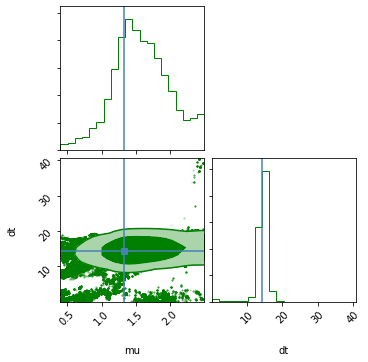


Maximum likelihood Estimation
-----------------------------


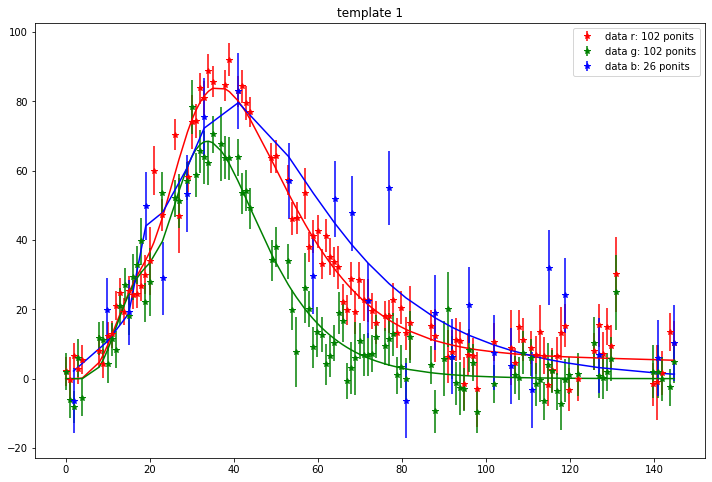

Maximum liklihood: mu= 1.4854056661971689 dt= 14.440813785978888

Chi^2 r= 101.99501509692058 Chi^2 g= 91.73626484294138 Chi^2 i= 39.93155440115984
data points::: r-band: 102  g-band: 102  i-band: 26


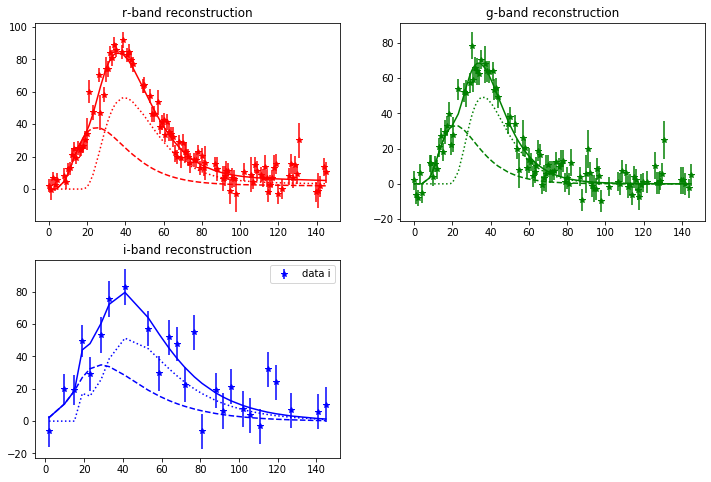

In [39]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1